In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip3 install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 98.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 119.9 MB/s eta 0:00:00


In [ ]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)

In [ ]:
model_name_or_path = 'gpt2'

## Data Pre-processing

### Read dataset file

In [ ]:
import pandas as pd
import numpy as np

train_filename = "/content/drive/MyDrive/NLP Project/Datasets/AFND/train.csv"
test_filename = "/content/drive/MyDrive/NLP Project/Datasets/AFND/test.csv"




df_train = pd.read_csv(train_filename)
df_test = pd.read_csv(test_filename)

In [ ]:
label_mapping = {1:'fake', 0:'real'}
df_train.label = df_train.label.map(label_mapping)
df_test.label = df_test.label.map(label_mapping)

In [ ]:
df_train.head()

,text,label
0,ايران تبدا اختبار انظمة التبريد مفاعل اراكستخت...,real
1,بومبيو استبعد ترشحي انتخابات الراسة الامريكية ...,real
2,هبوطا باسعار النفط عقب اعلان تعويم السفينة الب...,real
3,عودة المهاجرين فرنسا ستكون وفق الاطر القانونية...,fake
4,ريس الوزرا يتفقد مركز لقاحات كورونا بارض المعا...,real


In [ ]:
df_test.head()

,text,label
0,وفيات الثلاثا اقرا ايضا وفيات وعشرات الاصابات ...,fake
1,الضمان مدرسة تعهدت بتقديم رسوم سواليف قال النا...,fake
2,اقل الف وفاة يومية بكورونا امريكا للمرة الاولي...,fake
3,تتدخل مسال اجتماعية تعنيكعلق الامين العام السا...,fake
4,وفاة الامير فيليب زوج ملكة بريطانيا الملكة الي...,fake


In [ ]:
df_train.loc[df_train.label == 'fake'].sample(10)

,text,label
36407,مراكش تواصل حملة التبرع بالدم بكلية الاداب وال...,fake
59058,سفير المانيا بالقاهرة التعاون التعليم العالي و...,fake
52974,وصول الشحنة الاولي لقاح فايزر الامريكي الي طرا...,fake
44908,بيروت وبغداد النفط مقابل العلاجوقع لبنان والعر...,fake
58820,الدبيبة يقدم قامة حكومة الوحدة الوطنية الخميسق...,fake
49049,ضبط سلاح نوع كارلو واعتقال مشتبه مجد الكرومجا ...,fake
2789,الجيش الصحراوي ينفذ هجمات جديدة ضد تخندقات جنو...,fake
11312,يمكن للجامعة ان تلغي عقوبة الشابة اللجو الي جل...,fake
6656,الغا نقلة بشير العكرمي وكالة الجمهورية بتونس ق...,fake
54928,فعاليات اليومين الثاني والثالث والتوصيات للمنت...,fake


### Get the values of DataFrame

In [ ]:
train_labels = df_train['label'].tolist()
train_text = df_train['text'].tolist()

test_labels = df_test['label'].tolist()
test_text = df_test['text'].tolist()

assert len(train_labels) == len(train_text)
assert len(test_labels) == len(test_text)

print("len(train_text) = {}, len(test_text) = {}".format(len(train_text), len(test_text)))

len(train_text) = 64000, len(test_text) = 16000


In [ ]:
def unique(list1):
 
    # initialize a null list
    unique_list = []
 
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    # print list
    for x in unique_list:
        print (x)

In [ ]:
unique(train_labels)

real
fake


### Get values indices

In [ ]:
def format_label_value(labels):
    """
    Formats a list of labels to corresponding numeric values.
    """
    format_label_list = []

    for label in labels:
        if label == "fake":
            format_label_list.append(0)
        elif label == "real":
            format_label_list.append(1)
        
    
    return format_label_list

In [ ]:
train_labels = format_label_value(train_labels)
test_labels = format_label_value(test_labels)

In [ ]:
len(train_labels)

64000

## GPT2 Tokenization & Input Formatting

### GPT2 Tokenization

In [ ]:
# Get model configuration.
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=2)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token


Loading configuraiton...


Loading tokenizer...


In [ ]:
# Print the original sentence.
print('Original: ', train_text[0])
print("len(Original) = ", len(train_text[0]))
print("\n")

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(train_text[0]))
print("len(Tokenized) = ", len(tokenizer.tokenize(train_text[0])))
print("\n")

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_text[0])))
print("len(Token IDs) = ", len(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_text[0]))))
print("\n")

Original:  ايران تبدا اختبار انظمة التبريد مفاعل اراكستختبر ايران انظمة التبريد مفاعل اراك النووي تمهيدا لتشغيله بشكل كامل العام اعلنت منظمة الطاقة الذرية الايرانية اليوم الجمعة ونقلت وسال اعلام المتحدث باسم المنظمة بهروز كمالوندي قوله ان اختبار التبريد يشمل عادة تشغيل انظمة السوال وانظمة الدعم سيكون اوال السنة الفارسية الجديدة تبدا يوم الاحد المقبل وقال كمالوندي بمعني اخر حققنا تقدما العمل بقطاعات الوقود والتخزين وزادت ايران الاونة الاخيرة وتيرة انتهاك بنود الاتفاق النووي الدولي الموقع عام محاولة يبدو للضغط الريس الامريكي جو بايدن للعدول قرار سلفه دونالد ترامب الانسحاب الاتفاق والمواجهة قامة الجانبين يجب ان يبادر بالتحرك لانقاذ الاتفاق كانت ايران وافقت اغلاق مفاعل اراك يقع كيلومترا طهران بموجب اتفاق مسموحا بانتاج كمية محدودة الما الثقيل عملت اعادة تصميم المفاعل تقول انها تعتزم انتاج نظار لاغراض طبية وزراعية وقالت الوكالة الدولية للطاقة الذرية تقرير لدولها الاعضا الاسبوع ان ايران بدات تخصيب اليورانيوم محطة نطنز الارض باستخدام نوع ثان اجهزة الطرد المركزي المتقدمة اي ار انتهاك جديد للاتف

### Input Formatting for GPT2

In [ ]:
import logging

# Set logger to avoid warning `token indices sequence length is longer than the specified maximum sequence length for this model (1017 > 512)`
logging.getLogger("transformers.tokenization_utils").setLevel(logging.ERROR)


def text_to_id(tokenizer, text_list):
    """
    It is a function to transform text to id.
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    """
    ids_list = []
    
    for item in text_list:
        # Sentence to id and add [CLS] and [SEP]
        encoded_item = tokenizer.encode(item, add_special_tokens=True)
        ids_list.append(encoded_item)
    
    return ids_list

In [ ]:
for i in range(len(train_text)):
    if not isinstance(train_text[i], str):
        train_text[i] = str(train_text[i])

In [ ]:
for i in range(len(test_text)):
    if not isinstance(test_text[i], str):
        test_text[i] = str(test_text[i])

In [ ]:
train_text_ids = text_to_id(tokenizer, train_text)
test_text_ids = text_to_id(tokenizer, test_text)


# Print sentence 0, now as a list of IDs.
print('Original: {}\n'.format(train_text[0]))
print('Token IDs: {}\n'.format(train_text_ids[0]))
print("len(train_text_ids) = {}\n".format(len(train_text_ids)))
print("len(test_text_ids) = {}".format(len(test_text_ids)))

Token indices sequence length is longer than the specified maximum sequence length for this model (1404 > 1024). Running this sequence through the model will result in indexing errors


Original: ايران تبدا اختبار انظمة التبريد مفاعل اراكستختبر ايران انظمة التبريد مفاعل اراك النووي تمهيدا لتشغيله بشكل كامل العام اعلنت منظمة الطاقة الذرية الايرانية اليوم الجمعة ونقلت وسال اعلام المتحدث باسم المنظمة بهروز كمالوندي قوله ان اختبار التبريد يشمل عادة تشغيل انظمة السوال وانظمة الدعم سيكون اوال السنة الفارسية الجديدة تبدا يوم الاحد المقبل وقال كمالوندي بمعني اخر حققنا تقدما العمل بقطاعات الوقود والتخزين وزادت ايران الاونة الاخيرة وتيرة انتهاك بنود الاتفاق النووي الدولي الموقع عام محاولة يبدو للضغط الريس الامريكي جو بايدن للعدول قرار سلفه دونالد ترامب الانسحاب الاتفاق والمواجهة قامة الجانبين يجب ان يبادر بالتحرك لانقاذ الاتفاق كانت ايران وافقت اغلاق مفاعل اراك يقع كيلومترا طهران بموجب اتفاق مسموحا بانتاج كمية محدودة الما الثقيل عملت اعادة تصميم المفاعل تقول انها تعتزم انتاج نظار لاغراض طبية وزراعية وقالت الوكالة الدولية للطاقة الذرية تقرير لدولها الاعضا الاسبوع ان ايران بدات تخصيب اليورانيوم محطة نطنز الارض باستخدام نوع ثان اجهزة الطرد المركزي المتقدمة اي ار انتهاك جديد للاتفا

In [ ]:
print('Train: max sentence length: ', max([len(sen) for sen in train_text_ids]))
print('Train: Min sentence length: ', min([len(sen) for sen in train_text_ids]))
print('Test: max sentence length: ', max([len(sen) for sen in test_text_ids]))
print('Test: Min sentence length: ', min([len(sen) for sen in test_text_ids]))

Train: max sentence length:  87621
Train: Min sentence length:  46
Test: max sentence length:  40514
Test: Min sentence length:  59


### Padding & Truncating

In [ ]:
def padding_truncating(input_ids_list, max_length):
    """
    It is a function to perform padding and truncating
    @param input_ids_list: <List> text_ids
    @param max_length: <Integer> the number we wanna the sentence to be padding or truncating
    @return: processed input_ids_list
    """
    processed_input_ids_list = []
    for item in input_ids_list:
        seq_list = []
        
        if len(item) < max_length:
            # Define a seq_list with the length of max_length
            seq_list = [0] * (max_length - len(item))
            item = item + seq_list
        
        elif len(item) >= max_length:
            item = item[:max_length]
            
        processed_input_ids_list.append(item)
    
    return processed_input_ids_list

In [ ]:
train_padding_list = padding_truncating(train_text_ids, max_length=50)
test_padding_list = padding_truncating(test_text_ids, max_length=50)

### Attention Masks

In [ ]:
def get_attention_masks(pad_input_ids_list):
    """
    It is a function to get attention masks:
    
    - If a token ID is 0, then it's padding, set the mask to 0.
    - If a token ID is > 0, then it's a real token, set the mask to 1.
    """
    attention_masks_list = []
    
    for item in pad_input_ids_list:
        
        mask_list = []
        for subitem in item:
            if subitem > 0:
                mask_list.append(1)
            else:
                mask_list.append(0)
        attention_masks_list.append(mask_list)
    
    return attention_masks_list

In [ ]:
train_attention_masks = get_attention_masks(train_padding_list)
test_attention_masks = get_attention_masks(test_padding_list)

assert len(train_text) == len(train_labels) == len(train_attention_masks) == len(train_padding_list), "Training data length mismatch"
assert len(test_text) == len(test_labels) == len(test_attention_masks) == len(test_padding_list), "Testing data length mismatch"


In [ ]:
print(len(train_text), len(train_labels), len(train_attention_masks), len(train_padding_list))


64000 64000 64000 64000


### Split train dataset into train_dataset and validation_dataset


In [ ]:
from sklearn.model_selection import train_test_split

# Use 90% for training and 10% for validation.
train_padding_list, validation_padding_list, train_labels, validation_labels, train_attention_masks, validation_attention_masks = train_test_split(train_padding_list, train_labels, train_attention_masks, random_state=2020, test_size=0.1)


In [ ]:
assert len(train_labels) == len(train_attention_masks) == len(train_padding_list)
assert len(validation_labels) == len(validation_attention_masks) == len(validation_padding_list)
assert len(test_labels) == len(test_attention_masks) == len(test_padding_list)

In [ ]:
print("len(train_labels) = {}\nlen(validation_labels) = {}\nlen(test_labels) = {}".format(len(train_labels), len(validation_labels), len(test_labels)))


len(train_labels) = 57600
len(validation_labels) = 6400
len(test_labels) = 16000


### Convert to Dataset

Convert all the List objects to tensor

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Convert all inputs and labels into torch tensors, the required datatype for our model.
train_inputs = torch.tensor(train_padding_list)
validation_inputs = torch.tensor(validation_padding_list)
test_inputs = torch.tensor(test_padding_list)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
test_labels = torch.tensor(test_labels)

train_masks = torch.tensor(train_attention_masks)
validation_masks = torch.tensor(validation_attention_masks)
test_masks = torch.tensor(test_attention_masks)

Form the Dataset with torch.tensor

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

batch_size = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Create the DataLoader for our test set.
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

## Train GPT2 Text Classification Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Get the actual model.
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`


### Optimizer & Learning Rate Scheduler

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs
print("total_steps = {}".format(total_steps))

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

total_steps = 14400


### Train

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import random

# Set the seed value all over the place to make this reproducible.
seed_val = 12345

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(epochs):
    
    ##########################################
    #               Training                 #
    ##########################################
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 10 batches.
        if step % 10 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Clear the gradients.
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we have provided the `labels`.
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end. 
        # `loss` is a Tensor containing a single value; the `.item()` function just returns the Python value from the tensor.
        total_loss += loss.item()

        # Perform a `backward` pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
        
    ##########################################
    #               Validation               #
    ##########################################
    # After the completion of each training epoch, measure our performance on our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to device
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            # token_type_ids is the same as the "segment ids", which differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        # flat_accuracy(y_pred, y_true)
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    10  of  3,600.    Elapsed: 0:00:04.
  Batch    20  of  3,600.    Elapsed: 0:00:06.
  Batch    30  of  3,600.    Elapsed: 0:00:08.
  Batch    40  of  3,600.    Elapsed: 0:00:09.
  Batch    50  of  3,600.    Elapsed: 0:00:11.
  Batch    60  of  3,600.    Elapsed: 0:00:13.
  Batch    70  of  3,600.    Elapsed: 0:00:14.
  Batch    80  of  3,600.    Elapsed: 0:00:16.
  Batch    90  of  3,600.    Elapsed: 0:00:18.
  Batch   100  of  3,600.    Elapsed: 0:00:19.
  Batch   110  of  3,600.    Elapsed: 0:00:21.
  Batch   120  of  3,600.    Elapsed: 0:00:23.
  Batch   130  of  3,600.    Elapsed: 0:00:24.
  Batch   140  of  3,600.    Elapsed: 0:00:26.
  Batch   150  of  3,600.    Elapsed: 0:00:28.
  Batch   160  of  3,600.    Elapsed: 0:00:29.
  Batch   170  of  3,600.    Elapsed: 0:00:31.
  Batch   180  of  3,600.    Elapsed: 0:00:33.
  Batch   190  of  3,600.    Elapsed: 0:00:34.
  Batch   200  of  3,600.    Elapsed: 0:00:36.
  Batch   210  of

### Plot

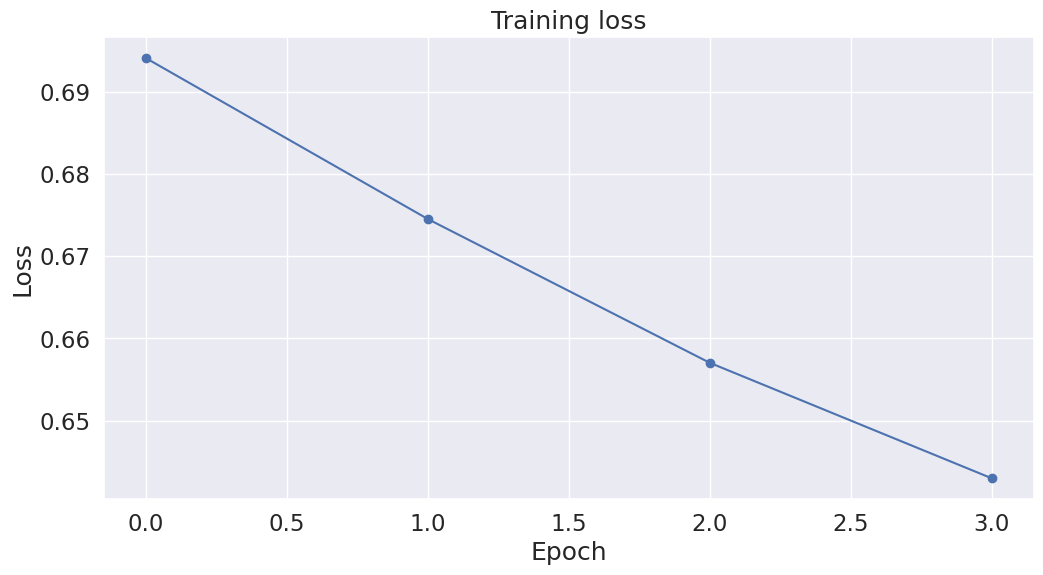

In [ ]:
import matplotlib.pyplot as plt

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

### Evaluation

In [ ]:
print('Predicting labels for {:,} test sentences...'.format(len(test_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions, true_labels = [], []

# Predict 
total_correct = 0
for idx, batch in enumerate(test_dataloader):
    
    print("Batch {}".format(idx + 1))
    
    # Add batch to device
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    # Get the prediction probability
    logits = outputs[0]
    
    # Get the prediction label
    pred = torch.argmax(logits, dim=1)
   
    # Get the number of correct predictions in this batch
    batch_correct = (pred == b_labels).sum().item()
    print("Batch correct = {}\n".format(batch_correct))
    
    # Accumulate the number of correct predictions over all batches
    total_correct += batch_correct
    
    # Append the predicted labels and true labels for this batch
    predictions.append(pred.cpu().numpy())
    true_labels.append(b_labels.cpu().numpy())
    

print('DONE.')
print("Total correct = ", total_correct)
print("Test accuracy = {0:.2f}".format(total_correct / len(test_inputs)))

# Concatenate the predicted labels and true labels over all batches
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Print classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(true_labels, predictions))
print(confusion_matrix(true_labels, predictions))

Predicting labels for 16,000 test sentences...
Batch 1
Batch correct = 12

Batch 2
Batch correct = 7

Batch 3
Batch correct = 10

Batch 4
Batch correct = 8

Batch 5
Batch correct = 12

Batch 6
Batch correct = 10

Batch 7
Batch correct = 12

Batch 8
Batch correct = 10

Batch 9
Batch correct = 11

Batch 10
Batch correct = 14

Batch 11
Batch correct = 11

Batch 12
Batch correct = 10

Batch 13
Batch correct = 6

Batch 14
Batch correct = 12

Batch 15
Batch correct = 10

Batch 16
Batch correct = 11

Batch 17
Batch correct = 12

Batch 18
Batch correct = 11

Batch 19
Batch correct = 7

Batch 20
Batch correct = 9

Batch 21
Batch correct = 8

Batch 22
Batch correct = 7

Batch 23
Batch correct = 11

Batch 24
Batch correct = 10

Batch 25
Batch correct = 9

Batch 26
Batch correct = 11

Batch 27
Batch correct = 12

Batch 28
Batch correct = 12

Batch 29
Batch correct = 8

Batch 30
Batch correct = 9

Batch 31
Batch correct = 10

Batch 32
Batch correct = 13

Batch 33
Batch correct = 11

Batch 34
Batch 